# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.mlab import PCA
import sklearn.decomposition as sk_decomp
import pandas as pd
from sklearn.preprocessing import StandardScaler


# Basic parameters

In [2]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp" 
# if not os.path.isdir(HCP_DIR):
#   os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

Manually downloaded the data from the following urls:

rest data: https://osf.io/bqp7m/download/

task data: https://osf.io/s4h8j/download/

covariates: https://osf.io/x5p4g/download/

The data is formatted into one big folder called hcp and each subject folder is seperately loaded according to its original folder name (eg. the subjects folder in hcp_task became subjects_task)

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [3]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

# Helper functions


## Data loading

In [4]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, subjects, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    subjects (str): task-organized folders, either _rest, _task, or _covariates
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, subjects, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, subjects, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    subjects (str): task-organized folders, either _rest, _task, or _covariates
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/{subjects}/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, subjects, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    subjects (str): task-organized folders, either _rest, _task, or _covariates
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/{subjects}/{subject}/EVs/{task_key}/{condition}.txt"
    ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
    evs.append(ev)
  return evs

## Task-based analysis

In [5]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run. Pertains to tasks and covariates, not resting state.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

## Working Memory Analysis

Array Shape: (360, 405)


Text(0.5, 0, 'Time')

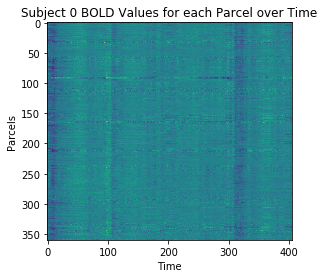

In [6]:
# for subject 0 

working_mem = load_timeseries(subject=0, subjects="subjects_task", name="wm", runs=1)
print("Array Shape:", working_mem.shape) # for 1 subject, 1 run: ts, n_parcel x n_tp_array

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Subject 0 BOLD Values for each Parcel over Time')
plt.imshow(working_mem)
ax.set_ylabel('Parcels')
ax.set_xlabel('Time')

Array Shape: (360, 1200)


Text(0.5, 0, 'Time')

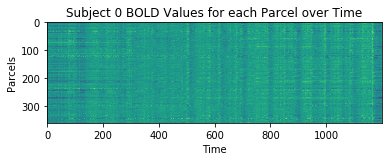

In [7]:
rest_stuff = load_timeseries(subject=0, subjects="subjects_rest", name="rest", runs=1)
print("Array Shape:", rest_stuff.shape) # for 1 subject, 1 run: ts, n_parcel x n_tp_array

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Subject 0 BOLD Values for each Parcel over Time')
plt.imshow(rest_stuff)
ax.set_ylabel('Parcels')
ax.set_xlabel('Time')

In [35]:
# is this necessary??
# for all subject, not concatenated 

timeseries_wm = []
timeseries_rest = []
for subject in subjects:
  #timeseries_wm.append(load_timeseries(subject, "subjects_task", "wm", concat=False))
  timeseries_rest.append(load_timeseries(subject, "subjects_rest", "rest", runs=1, concat=False)) # remove the runs input variable here to get them all 
  #timeseries_rest.append(np.load(f"{HCP_DIR}/subjects_rest/{subject}/timeseries/bold1_Atlas_MSMAll_Glasser360Cortical.npy").T)


rest_guy = pd.DataFrame(timeseries_rest[:][0][0])


# do stuff here to make the 1200 seconds 400 seconds by averaging each 3 seconds and save that ! and then save that new thing as rest_guy to replace the other one


,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,-137.149583,-212.849583,-266.649583,-297.149583,-277.849583,-235.649583,-223.749583,-195.449583,-171.349583,-181.149583,...,-143.149583,-111.049583,-117.649583,-107.149583,-82.849583,-64.949583,-65.749583,6.150417,26.850417,60.050417
1,-112.336858,-183.796858,-209.096858,-164.196858,-206.446858,-177.666858,-92.946858,-113.646858,-96.926858,-102.176858,...,-117.936858,-89.096858,-153.386858,-112.726858,-148.796858,-118.086858,-67.276858,-62.526858,-10.316858,-48.126858
2,-130.100333,-159.800333,-216.500333,-232.500333,-126.800333,-136.500333,-138.400333,-158.500333,-207.500333,-189.500333,...,-207.400333,-217.800333,-96.800333,-177.000333,-177.400333,-63.500333,-80.100333,-58.900333,-86.700333,-87.800333
3,-91.697583,-167.297583,-210.797583,-218.897583,-193.797583,-183.297583,-141.597583,-160.597583,-123.597583,-153.397583,...,-237.497583,-221.697583,-202.897583,-196.097583,-186.297583,-136.897583,-114.397583,-83.197583,-53.797583,-28.997583
4,-35.817833,-116.317833,-156.817833,-166.417833,-146.117833,-161.117833,-139.517833,-131.417833,-121.417833,-113.417833,...,-229.517833,-214.417833,-170.217833,-150.617833,-164.617833,-108.917833,-89.117833,-76.117833,-52.717833,-22.417833
5,-83.585083,-150.785083,-202.085083,-173.785083,-178.185083,-166.585083,-95.985083,-112.685083,-95.285083,-98.085083,...,-181.085083,-167.085083,-167.885083,-167.285083,-147.985083,-121.285083,-135.685083,-90.985083,-86.685083,-29.185083
6,-73.820000,-151.720000,-148.220000,-52.320000,-50.420000,-120.320000,-71.320000,-40.020000,-10.820000,-11.020000,...,-212.120000,-81.720000,-149.820000,-76.920000,-51.620000,-38.320000,46.080000,106.180000,80.880000,104.280000
7,52.233617,14.193617,2.293617,-40.196383,-17.026383,3.533617,6.853617,-3.006383,-5.126383,-8.816383,...,-126.086383,-86.706383,-112.236383,-82.086383,-101.926383,-81.676383,-67.866383,-66.996383,-36.796383,-39.436383
8,113.794058,38.984058,18.854058,-43.795942,-45.665942,-17.155942,7.584058,3.434058,-48.195942,-32.805942,...,-149.035942,-111.285942,-109.675942,-122.415942,-92.695942,-102.815942,-135.255942,-70.155942,-60.835942,-44.695942
9,158.852083,24.752083,42.052083,-31.147917,42.252083,97.452083,79.452083,79.252083,77.352083,62.452083,...,-202.147917,-172.547917,-197.747917,-146.347917,-160.247917,-149.547917,-141.647917,-122.047917,-95.147917,-79.247917


In [ ]:
# save rest_guy as a csv 
rest_guy.to_csv() # its a pd.dataframe thing

In [8]:
print(len(timeseries_wm[1]))

IndexError: list index out of range

In [15]:
print(len(timeseries_rest[1]))

1


In [16]:
print(len(evs))

2


In [24]:
np.load(f"{HCP_DIR}/subjects_rest/0/timeseries/bold1_Atlas_MSMAll_Glasser360Cortical.npy").shape

(360, 1200)

In [28]:
timeseries_rest -= timeseries_rest.mean(axis=1, keepdims=True)
print(len(timeseries_rest))

AttributeError: 'list' object has no attribute 'mean'

In [25]:
np.load(f"{HCP_DIR}/subjects_task/0/timeseries/bold5_Atlas_MSMAll_Glasser360Cortical.npy").shape

(360, 284)

In [18]:
task = "wm"

conditions = ["0bk_body", "0bk_faces", "0bk_nlr", "0bk_places", "0bk_tools", 
    "2bk_body", "2bk_faces", "2bk_nlr", "2bk_places", "2bk_tools",
    "0bk_cor", "0bk_err",
    "2bk_cor", "2bk_err",
    "all_bk_cor", "all_bk_err"]

conditions = ["0bk_cor", "2bk_cor"] # i didnt include 0bkerr bc it was usually 0 and the system would crash! maybe we should update conditional frames to not crash if the list is 0 

## i cant get the error stuff working yikes

contrast = []

zerobkcor = []
twobkcor = []
# zerobkerr = []
# twobkerr = []
wm = []
rest = []
#timeseries_wm = []

for subject in subjects:
  # rest data
  #rest = load_timeseries(subject, "subjects_rest", "rest", concat=False)
  # task data
  #wm = load_timeseries(subject, "subjects_task", "wm", concat=False)

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, "subjects_task", task, cond) for cond in conditions]
  print(evs)
  print(subject)
  #avgs = [selective_average(wm[subject], ev) for ev in evs]
  avgs = [selective_average(timeseries_wm[subject], ev) for ev in evs]
  
  avgs = [selective_average(timeseries_rest[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0] - avgs[1])
  zerobkcor.append(avgs[0])
  twobkcor.append(avgs[1])
  # twobkerr.append(avgs[2])

# average across subjects to produce a generalized description for each region
# group_contrast = np.mean(contrast, axis=0) # why do they do this????
# group_zerobkcor = np.mean(zerobkcor, axis=0)
# group_twobkcor = np.mean(twobkcor, axis=0)
# group_twobkerr = np.mean(twobkerr, axis=0)


[[{'onset': array([ 38.704,  41.277,  43.849,  46.421,  48.994,  51.566,  54.138,
        56.71 ,  59.283,  61.855, 109.996, 112.568, 115.127, 117.686,
       120.258, 122.817, 125.376, 127.935, 130.494, 133.066, 153.138,
       155.71 , 158.283, 160.855, 163.427, 165.999, 168.572, 171.144,
       173.716, 176.289, 224.602, 227.188, 229.747, 232.333, 234.905,
       237.477, 240.036, 242.595, 245.154, 247.713]), 'duration': array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
       2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
       2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
       2.5]), 'amplitude': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])}, {'onset': array([ 38.691,  41.264,  43.836,  46.395,  48.954,  51.513,  54.085,
        56.644,  59.203,  61.762, 110.036, 112.595, 115.154, 117.

ValueError: Length of `timeseries_data` and `ev` must match.

In [42]:
# save to df 
df_zerobkcor = pd.DataFrame(zerobkcor) # 338 subject averages for all 360 regions

# print(df)

# Standardize!
x_zerobkcor = StandardScaler().fit_transform(df_zerobkcor)

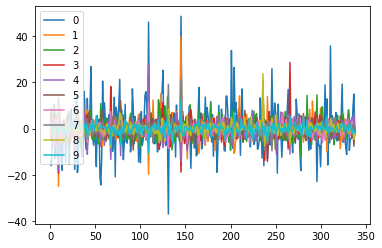

In [56]:
#PCA

n_comp = 10

pca = sk_decomp.PCA(n_components=n_comp)
components = pca.fit_transform(x_zerobkcor)

principalDf = pd.DataFrame(data = components) #, columns = ['principal component 1', 'principal component 2'])

# print(principalDf)

principalDf.plot()



## we should take this time to save all necessary data as a csv and delete everything else (variables) to save memory

In [9]:
## save to csv: group data by region



## Display Working Memory Task Data

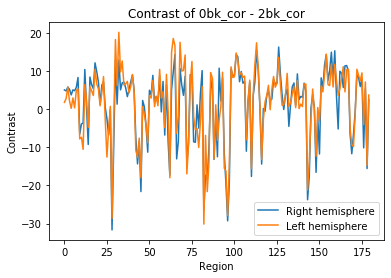

In [10]:
hemi_contrasts = np.split(group_contrast, 2)

for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

Plot group-averaged contrast value across regions:

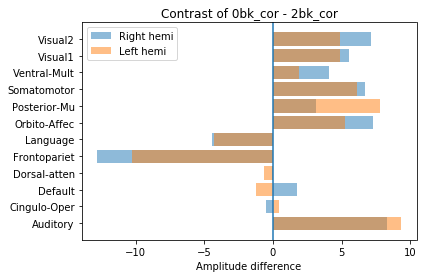

In [12]:
## Functional Network Analysis

# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()

Plot the profile of FC values between a particular "seed" parcel and every parcel in the dataset, separated by hemisphere:

In [15]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_wm):
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

ValueError: m has more than 2 dimensions

In [ ]:
seed_roi = "R_FEF"  # name of seed parcel
ind = region_info["name"].index(seed_roi)

hemi_fc = np.split(group_fc, 2)

# Plot the FC profile across the right and left hemisphere target regions
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, ind], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

# Working Memory Behavior Stuff

In [27]:
wm_behavior = np.genfromtxt("hcp/behavior/wm.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(wm_behavior[:5])
print(wm_behavior.dtype.names)

[(0, 0, '0BK_BODY', 1., 1., 1.,  705.5,  740.5, 696. )
 (0, 0, '0BK_FACE', 1., 1., 1.,  779.5,  765. , 915. )
 (0, 0, '0BK_PLACE', 1., 1., 1.,  926. ,  993.5, 811.5)
 (0, 0, '0BK_TOOL', 1., 1., 1.,  807.5,  807.5, 807.5)
 (0, 0, '2BK_BODY', 1., 1., 1., 1133. , 1205.5, 732.5)]
('Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET')


## Resting State Analysis

In [17]:
timeseries = load_timeseries(subject=0, subjects="subjects_rest", name="rest", runs=1)

print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


In [18]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "subjects_rest", "rest")
  timeseries_rest.append(ts_concat)

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## Characterize values by functional network

Average the contrast values within parcels belonging to each network and plot:

In [90]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()

NameError: name 'region_info' is not defined

# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [91]:
wm_behavior = np.genfromtxt("hcp/behavior/wm.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(wm_behavior[:5])
print(wm_behavior.dtype.names)

[(0, 0, '0BK_BODY', 1., 1., 1.,  705.5,  740.5, 696. )
 (0, 0, '0BK_FACE', 1., 1., 1.,  779.5,  765. , 915. )
 (0, 0, '0BK_PLACE', 1., 1., 1.,  926. ,  993.5, 811.5)
 (0, 0, '0BK_TOOL', 1., 1., 1.,  807.5,  807.5, 807.5)
 (0, 0, '2BK_BODY', 1., 1., 1., 1133. , 1205.5, 732.5)]
('Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET')


But, while not formally taught as part of the course, [`pandas`](https://pandas.pydata.org/) offers more powerful tools for tabular data analysis.

## Pseudo-demographics

The NMA-distributed version of the HCP data does not contain any real demographic information. But we have created a synthetic dataset of 25 "demographic" variables based on a model trained on the original dataset to predict demographics from resting-state network organization measures:

In [92]:
demo = np.load("hcp/pseudo_demographics.npy")
demo.shape

(339, 25)

## Original subject IDs

The dataset also contains a key to map the ordinal subject numbers to the IDs used in the original HCP dataset:

In [93]:
ids = np.loadtxt("hcp/orig_ids.txt")
print(ids[:8])

[199453. 580751. 173435. 919966. 181636. 192843. 894067. 174437.]
